In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
# Download the inception v3 weights
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
# pre_trained_model.load_weights(local_weights_file)
# No longer needed with weights = "imagenet" parm to 
# tf.keras.applications.InceptionV3(input_shape = , include_top = , weights = 'imagenet')
# Create an instance of the inception model from the local pre-trained weights
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# keras allows for very simple transfer learning with the 
# keras.applications API
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

67[0][0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 7, 7, 192)    147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 7, 7, 192)    576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 7, 7, 192)    576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 7, 7, 192)    576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 7, 7, 192)    576         conv2d_69[0][0]      

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class earlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    print(logs)
    if(logs.get('acc')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True      

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

              
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 160)    0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 7, 7, 160)    122880      mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 7, 7, 160)    179200      activation_45[0][0]              
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 7, 7, 160)    480         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 7, 7, 160)    480         conv2d_46[0][0]              

In [6]:
# # Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# # Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2020-05-14 09:45:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4006:802::2010, 172.217.11.16
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4006:802::2010|:443...connected.
HTTP request sent, awaiting response...200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  10.7MB/s    in 14s     

2020-05-14 09:45:18 (10.4 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-05-14 09:45:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4006:802::2010, 172.217.11.16
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4006:802::2010|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: 11480187 

In [7]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [8]:
# Add our data-augmentation parameters to ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1.0/255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    batch_size = 20, 
    class_mode = 'binary', 
    target_size = (150, 150)
)      


# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    validation_dir, 
    batch_size = 20, 
    class_mode = 'binary', 
    target_size = (150,150)
)

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [9]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy
early_stopping = earlyStopping()
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs = 3, 
    callbacks = [early_stopping], 
    verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
52/52 [==============================] - 8s 152ms/step - loss: 0.1448 - acc: 0.9474 - val_loss: 0.0815 - val_acc: 0.9688
Epoch 2/3
52/52 [==============================] - ETA: 0s - loss: 0.0227 - acc: 0.9932{'loss': 0.022711804136633873, 'acc': 0.9931840300559998, 'val_loss': 0.03935736417770386, 'val_acc': 0.98828125}

Reached 97.0% accuracy so cancelling training!
52/52 [==============================] - 7s 134ms/step - loss: 0.0227 - acc: 0.9932 - val_loss: 0.0394 - val_acc: 0.9883


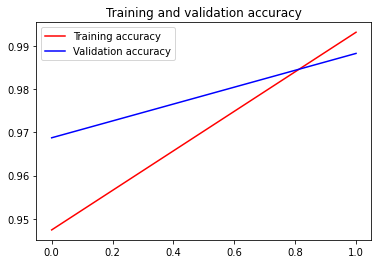

<Figure size 432x288 with 0 Axes>

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()